<a href="https://colab.research.google.com/github/adefuentes29/ejemplo1/blob/main/Bit%C3%A1cora_de_experimentos_Proyecto_Fase_3b_18Oct21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML con Python 

**Proyecto anterior:** Análisis de los incidentes viales para la determinación de distribuciones de densidad y comparativa de incidencia con las rutas del sistema de transporte y las principales vías de la CDMX

**Lenguaje de programación:** Python

**Equipo:** 5

**Integrantes:**

* Ximena Ávila Villagómez

* Félix Alberto Nieto García

* Alejandro De Fuentes Martínez

# Índice de contenido

0. Librerías

  0.1 Instalación de librerías

  0.2 Librerías utilizadas

1. Identificación del problema
2. Plantemiento de preguntas
3. Funciones

  3.1 Adquisición de datos mediante API y su tranformación

  3.2 Graficación

  3.3 Procesado

4. Colección de datos
  
  4.1 Incidentes víales C5

  4.2 Demarcación territorial de la CDMX

  4.3 Vías principales de la CDMX 

  4.4 Rutas de transporte de la CDMX

5. Análisis Multivariable para la predicción y clasificación

6. Predicción

7. Cluster


# 0. Librerias

### 0.1 Instalación de librerias 

In [ ]:
!pip install geojson;
!pip install geopandas;
!pip install pygeos
!pip install fiona shapely pyproj rtree

### 0.2 Librerias utilizadas

In [ ]:
#Manejo, tranformación y adquisición de datos
import pandas as pd 
import numpy as np  
import json #Manejo de archivos json
import requests #Para hacer solicitudes HTTP
import geojson
import geopandas as gpd
from shapely.geometry import Point, Polygon,LineString, MultiLineString

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#Graficación
import seaborn as sns  
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import folium  # Visualización de datos en mapas interactivos
import folium.plugins #Herramientas para mapas interactivos
import branca.colormap as cm

In [ ]:
#Calculos estadisticos y clasificación
from scipy import stats #1
from scipy.stats import skew, kurtosis #2
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
from sklearn.linear_model import LinearRegression

## 1. Identificación del problema

Los accidentes de tránsito son una de las principales causas de muerte a nivel nacional e incluso a nivel mundial, representan un problema de seguridad vial que requiere de un análisis cuidadoso así como de estudios continuos para buscar soluciones que disminuyan su frecuencia.

Durante las fases pasadas se exploró el problema por medio del procesamiento de datos sobre los accidentes viales en la CDMX registrados por el C5 desde 2014 hasta  principios de 2021. En la misma investigación se utilizaron datos sobre la ubicación de vías principales, de trásito de autobuses, estaciones, etc. Se observaron algunos hechos relevantes como los meses en los que ocurren más incidentes, los días y el tipo de accidente más frecuente por localización, las alcaldías con más accidentes dependiendo el tipo y posibles coincidencias con la concurrencia de las avenidas y la cantidad de accidentes. De esta forma, el problema se ha analizado y descrito detalladamente en entregas anteriores.

En este último módulo se explorarán las posibles predicciones de comportamientos para determinados tipos de incidentes viales, con el uso de Machine Learning. También se aplicarán algoritmos de clusterización a fin de explicar clasificaciones o agrupaciones de incidentes viales en función de variables identificadas. Esto brindaría información útil basada en evidencias de los datos para plantear estrategias de prevención así como sugerir perspectivas más amplias del problema.


## 2 Planteamiento de preguntas

**Preguntas iniciales sugeridas para el proyecto**
*   ¿Cómo se clasifican y se ven expresados en clústers con K-Means los distintos tipos de accidentes para las 16 alcaldías de las CDMX?
*   ¿Qué cantidad de accidentes pueden predecirse de un cierto tipo para una alcaldía en particular en un año próximo? Ejemplo -->
*   ¿Cómo el aumento de la cantidad de datos puede modificar la precisión, sensibilidad y especificidad del modelo planteado?

## 3. Funciones 

### 3.1 Adquisición de datos mediante API y su tranformación

In [ ]:
#Función para adquirir datos mediante API
def get_data_API(link):
  r = requests.get(link)
  r.status_code
  consulta = r.json()
  D = pd.json_normalize(consulta['result']['records'])
  r.close()
  df = pd.DataFrame.from_dict(D)
  return df

In [ ]:
def clean_data(df):
  col = df.columns
  if 'geometry' in col:
    geoname = 'geometry'
  elif 'geo_shape' in col:
    geoname = 'geo_shape'
  else:
    geoname = 'no'

  if 'geo_point_2d' in col:
    geopoint = 'geo_point_2d'
  elif "geopoint" in col:
    geopoint = 'geopoint'
  else:
    geopoint = 'no'


  if geoname != 'no':
    df['geometry'] = df[geoname].apply(lambda x: json.loads(x))

  if geopoint != 'no':
    df[['latitud','longitud']] = df[geopoint].str.split(',',expand=True).astype(float)

  borrar =  ['geo_shape','id','_id']
  b = []
  for i in borrar:
    if i in col:
      b.append(i)
  if geopoint != 'no':
    b.append(geopoint)
  
  df = df.drop(columns=b)

  return df

In [ ]:
def transform_geometry(diccionario):
  if diccionario['type'] == 'Polygon':
    return Polygon(diccionario['coordinates'][0])
  elif diccionario['type'] == 'LineString':
    return LineString(diccionario['coordinates'])
  elif diccionario['type'] == 'Point':
    return Point(diccionario['coordinates'])
  elif diccionario['type'] == 'MultiLineString':
      return MultiLineString(diccionario['coordinates'])

def set_geometry(df,columna):
  df[columna] = df[columna].apply(lambda x:transform_geometry(x))
  return gpd.GeoDataFrame(df,crs='EPSG:4326')

def transform_data(df):
  col = df.columns
  if ('geometry' in col) :
    df = set_geometry(df, columna='geometry')
  elif ('latitud' in col) and ('longitud' in col):
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitud'], df['latitud']),crs='EPSG:4326')
  
  elif 'WKT' in col:
    df['geometry'] = gpd.GeoSeries.from_wkt(df['WKT'])
    df = gpd.GeoDataFrame(df,geometry='geometry',crs='EPSG:4326')
    df = df.drop(columns=['WKT']) 

  return df

### 3.2 Graficación

In [ ]:
def add_data(data,mapa,nombre,color='black',grosor=0.5):
  capa = folium.FeatureGroup(nombre)
  for _, r in data.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                              style_function=lambda feature: { #'fillColor': 'blue',
                                                              'color' : color, 'weight' : grosor, 'fillOpacity' : 0} )
    
    geo_j.add_to(capa)
    capa.add_to(mapa)

In [ ]:
def graf_map_cloroplet(datos_geo,datos_num,columnas,mapa,titulo=''):
  folium.Choropleth(
      geo_data=datos_geo,
      name='Incidentes CDMX',
      data=datos_num,
      columns=columnas,
      key_on='feature.properties.'+columnas[0],
      fill_color='YlGn',
      fill_opacity=.5,
      legend_name=titulo
  ).add_to(mapa)

In [ ]:
def graf_clroplet_crostab(datos_geo,datos_num,columnas):
  df_data = datos_num.reset_index().rename(columns={'delegacion_inicio':'Alcaldia'})
  df_data = df_data.rename(columns= dict(zip(df_data.columns,df_data.columns.astype(str) )))
 
  centro = [19.432566, -99.133195]
  Tmap =['Stamen Terrain','CartoDB Positron','Mapbox', ]
  m = folium.Map(location= centro, tiles=Tmap[1],
                        zoom_start=10,prefer_canvas=True,
                        max_zoom=16,min_zoom=9,
                        width='65%',height='75%')
  
  graf_map_cloroplet(datos_geo,df_data,columnas,m,titulo = 'Incidentes '+columnas[1])
  folium.map.LayerControl('topleft', collapsed= False).add_to(m)

  style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                              'weight': 0.1}
  highlight_function = lambda x: {'fillColor': '#000000', 
                                  'color':'#000000', 
                                  'fillOpacity': 0.50, 
                                  'weight': 0.1}

  datos_geo['incidentes'] = df_data[columnas[1]].apply(lambda x: f'{x:,}')

  # Estructua tooltip
  NIL = folium.features.GeoJson(
      datos_geo,
      style_function=style_function, 
      control=False,
      highlight_function=highlight_function, 
      tooltip=folium.features.GeoJsonTooltip(
          fields= ['Alcaldia','incidentes'],
          aliases=['Alcaldia','incidentes'])    )
  
  m.add_child(NIL)
  m.keep_in_front(NIL)

  return m

In [ ]:
#Función para graficar los conteos de las variables categoricas
def graf_count(data,nombre,porcentaje = False,orien='v',):
  C = data[nombre].value_counts()
  if orien == 'h':
      if porcentaje == False:
        ax = sns.barplot(C,C.index,orient='h');
        ax.set(xlabel='count',title=nombre)
      else:
        P  = C*100/C.sum()
        ax = sns.barplot(P,P.index,orient='h');
        ax.set(xlabel='Porcentaje %',title=nombre)
  else:
    if porcentaje == False:
      ax = sns.barplot(C.index,C);
      ax.set(ylabel='count',title=nombre)
    else:
      P  = C*100/C.sum()
      ax = sns.barplot(P.index,P);
      ax.set(ylabel='Porcentaje %',title=nombre)

In [ ]:
#Función para graficar un histograma 2d, grafico de barras y la distribución en dos direcciones de un dataframe
def graf_bar_hist(data,xdata,ydata,delimitacion ='No', k=1/111.1,colormap="Blues",titulo=''):

  #Caracteristicas del plots
  fig, axes = plt.subplots(3, 3, figsize=(10, 10),
                           gridspec_kw={"height_ratios": (.2,0.1, .7),"width_ratios": (.7,0.1, .2)})
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02, hspace=0.02)

  #Colobar
  axins = inset_axes(axes[2,0],width="50%", height="2%",  loc='upper left', 
                     bbox_to_anchor=(0.02, 0.05, 0.9, 0.9), 
                     bbox_transform=axes[2,0].transAxes, borderpad=0)
  axins.set_title('No. Accidentes',fontsize=8)

  #General
  sns.histplot(data=data ,x=xdata, y=ydata,cmap= colormap,ax=axes[2,0],
               binwidth=k,kde=True,cbar=True,
               cbar_kws={'orientation':'horizontal'},cbar_ax=axins)
  
  axes[0,2].text(x=-0.2,y=0.8,s=titulo,fontsize=13)
  axes[0,2].text(x=-0.2,y=0.6,s='Datos')
  axes[0,2].text(x=-0.2,y=0.4,s=f'Curtosis x: {round(kurtosis(data[xdata]),4)}\nAsimetría x: {round(skew(data[xdata]),4)}')
  axes[0,2].text(x=-0.2,y=0,s=f'Curtosis y: {round(kurtosis(data[ydata]),4)}\nAsimetría y: {round(skew(data[ydata]),4)}')
  axes[0,2].text(x=-0.2,y=-0.2,s=f'width bins={round(k,4)}°({round(k*111.1,4)}km)')

  #latitud
  sns.histplot(data=data,x=xdata , binwidth=k,kde=True,ax=axes[0,0])
  axes[0,0].axvline(data[xdata].quantile(0.5), color='red')
  #axes[0,1].text(x=0.1,y=0.5,s=f'Curtosis: {round(kurtosis(data[xdata]),4)}\n Asimetría: {round(skew(data[xdata]),4)}')
  
  sns.boxplot(data=data,x=xdata,ax=axes[1,0])

  #longitud
  sns.histplot(data=data, y=ydata, binwidth=k,kde=True,ax=axes[2,2])
  axes[2,2].axhline(data[ydata].quantile(0.5), color='red')
  #axes[1,2].text(x=0,y=0.1,s=f'Curtosis: {round(kurtosis(data[ydata]),4)}\n Asimetría: {round(skew(data[ydata]),4)}')

  sns.boxplot(data=data,y=ydata,ax=axes[2,1])

  #Configuraciones
  borrar = [(0,1),(0,2),(1,2),(1,1)]
  for i in borrar:
    axes[i].axis('off')

  rnoshow = [ (0,0),(1,0)]
  for i in rnoshow:
    axes[i].set_xticklabels(())
    axes[i].set_xlabel(" ")

  cnoshow = [ (2,2),(2,1)]
  for i in cnoshow:
    axes[i].set_yticklabels(())
    axes[i].set_ylabel(" ")
  
  axes[2,0].set_xlim([data[xdata].min(),data[xdata].max()])
  axes[2,0].set_ylim([data[ydata].min(),data[ydata].max()])


  #Cuadrado
  xl = data[xdata].quantile([0.25 ,0.75,0.75,0.25,0.25]) 
  yl = data[ydata].quantile([0.25 ,0.25,0.75,0.75,0.25]) 


  #delimitacion territorial
  if type(delimitacion) == type(gpd.GeoDataFrame(columns=['A'])):
    delimitacion.plot(ax=axes[2,0],facecolor="none", edgecolor='black', lw=0.5,
                      figsize=(7,7))
    axes[2,0].set_aspect('auto')

  axes[2,0].plot(xl,yl,color='r',label='Rango Intercuantil', linestyle="--")
  axes[2,0].plot(data[xdata].quantile(0.5),data[ydata].quantile(0.5),'or')

  for i in  data[xdata].quantile([0.1,0.25,0.5,0.75,0.9]):
    axes[2,0].axvline(i, color='black',linewidth=0.5, linestyle="--")

  for i in  data[ydata].quantile([0.1,0.25,0.5,0.75,0.9]):
    axes[2,0].axhline(i, color='black',linewidth=0.5, linestyle="--")
  
  axes[2,0].axvline(data[ydata].quantile(0.5), color='black',linewidth=0.5, 
                    linestyle="--",label='cuantiles')
  axes[2,0].legend(loc='lower left')

  return fig,axes

In [ ]:
def circulos(data,x,y,mapa,radio=500,nombre='',color='crimson'):
  capa = folium.FeatureGroup(nombre)

  for i in range(0,len(data)):
    folium.Circle(
        location=[data.iloc[i][y], data.iloc[i][x]],
        #popup=data.iloc[i]['name'],
        radius=radio,
        color=color,
        fill=False ).add_to(capa)
  
  capa.add_to(mapa)

In [ ]:
def mapdata(data,mapa,tipo='heat'):
  heat_data = [[point.xy[1][0], point.xy[0][0]] for point in data.geometry ]

  if tipo == 'heat' :
    folium.plugins.HeatMap(heat_data).add_to(mapa)
  elif tipo == 'cluster':
    folium.plugins.MarkerCluster(heat_data).add_to(mapa)

### 3.3 Procesado

In [ ]:
def get_measures(columna):
  info = {}
  info['mean'] = columna.mean()
  info['median'] = columna.median()
  info['std'] = columna.std()
  info['trim mean'] = stats.trim_mean(columna, 0.1)
  info['max'] = columna.max()
  info['min'] = columna.min()
  info['range'] = info['max']-info['min']
  info['quantile'] = columna.quantile([0.1,0.25,0.5,0.75,0.9])
  info['range quantile'] = info['quantile'][0.75] - info['quantile'][0.25]

  return info

def get_info(df):
  data = {}
  for i in df.columns:
    data[i] = get_measures(df[i])
  return  pd.DataFrame.from_dict(data)


In [ ]:
#Función para realizar un filtro de los valores atípicos de una columande un dataframe
def filto_vatipicos(df,columna,porcentaje=1.5):
  iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25)
  filtro_inferior = df[columna] > df[columna].quantile(0.25) - (iqr * porcentaje)
  filtro_superior = df[columna] < df[columna].quantile(0.75) + (iqr * porcentaje)
  df_filtrado = df[columna][filtro_inferior & filtro_superior]
  
  return df.loc[df_filtrado.index]

#Función para realizar un filtro de los valores atípicos de las columnas seleccionadas
def datafiltro_vatipicos(df,columnas,porcentaje=1.5):
  new_data = df.copy()
  for i in columnas:
    new_data = filto_vatipicos(new_data,i,porcentaje=1.5)
  return new_data

In [ ]:
#Función para calcular la distribución de valores de algúna columna númerica
def distribucion(columnas,escala = 111.1):
  r = columnas.max()-columnas.min()
  bin = round(r*escala).astype('int64')
  table = {}
  for i,j in zip(bin.index,bin.values):
    seg = pd.cut(columnas[i],j)
    f = columnas[i].groupby(seg).count()
    table[i] = f
    return table

In [ ]:
def mayor_densidad(data,x,y,umbral,escala):
  columnas = data[[x,y]]
  M = columnas.max()
  m = columnas.min()

  segy = np.arange(m[y],M[y], escala)
  segx = np.arange(m[x],M[x], escala)  

  H, xedges, yedges = np.histogram2d(data[x], data[y], bins=(segx, segy))

  ind = np.where(H>umbral)

  yc = segy[ind[1]]
  xc = segx[ind[0]]

  return H,xc,yc

In [ ]:
#función que calcula los conteos de variables categoricas de und dataset
def frecuencias(data,columnas_categoricas):
  frecuencias_generales = {}
  for i in columnas_categoricas:
    frecuencias_generales [i] = data[i].value_counts()
  return frecuencias_generales


## 4 Coleccion de los datos

### 4.1 Incidentes víales C5 


El conjunto de datos que utilizamos corresponde a los [incidentes viales](https://datos.cdmx.gob.mx/dataset/incidentes-viales-c5) reportados por el  C5 de la CDMX desde 2014 hasta el 2021 y actualizado mensualmente. Se recolectaron dos datasets correspondientes a los años 2014-2020 y 2021 en la página de [datos abiertos de la ciudad de méxico](https://datos.cdmx.gob.mx). 




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [30]:
#Introduzca la ubicación de los datos de incidentes viales
path = "/content/drive/Shareddrives/DEBU/Datoschidos.csv"
data_incidentes = pd.read_csv(path,index_col='Unnamed: 0');

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
for i in ['fecha_creacion','fecha_cierre']:
  data_incidentes[i] = pd.to_datetime(data_incidentes[i])

In [32]:
data_code_A = transform_data(data_incidentes)

In [33]:
#Se seleccionan todos los datos que son afirmativos
data_code_A = data_incidentes[data_incidentes['codigo_cierre']== 'A']

In [34]:
data_code_A=data_code_A.reset_index(drop=True)

### 4.2 Demarcaciones territoriales de la CDMX

Los datos de la [delimitación territorial de la CDMX ](https://datos.cdmx.gob.mx/dataset/alcaldias) contiene información de las 16 alcaldías de las CDMX y sus respectivos conjuntos de puntos que crean polígonos delimitadores. 

In [35]:
#delimitación de las alcaldias
#https://datos.cdmx.gob.mx/dataset/limite-de-las-alcaldias/resource/dbb00cee-3660-43f6-89c2-8beb433292a8
link_alcaldia = 'https://datos.cdmx.gob.mx/dataset/bae265a8-d1f6-4614-b399-4184bc93e027/resource/e4a9b05f-c480-45fb-a62c-6d4e39c5180e/download/alcaldias.csv'

In [36]:
alcaldias = pd.read_csv(link_alcaldia)
alcaldias = clean_data(alcaldias)
alcaldias = transform_data(alcaldias)

In [37]:
alcaldias = alcaldias.drop(columns=['cvegeo','cve_ent','municipio'])
alcaldias=alcaldias.rename( columns={'nomgeo':'Alcaldia','cve_mun':'numero_id'})

In [38]:
alcaldias['Alcaldia'] = alcaldias['Alcaldia'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
alcaldias['Alcaldia'] = alcaldias['Alcaldia'].str.upper()
alcaldias = alcaldias.sort_values('Alcaldia').reset_index(drop=True)
alcaldias['Alcaldia'] =  alcaldias['Alcaldia'].str.replace('^LA ','').str.replace(' DE MORELOS','')

### 4.3 Vías principales de la CDMX

In [39]:
link_vias_principales = 'https://datos.cdmx.gob.mx/dataset/b3514d29-dedc-4006-90f3-156e0c56fb90/resource/44bc1807-a7ba-44a0-bf46-504623a30905/download/vialidades-de-la-ciudad-de-mexico.csv'

In [40]:
viasprincipales = pd.read_csv(link_vias_principales)
viasprincipales = clean_data(viasprincipales)
viasprincipales = transform_data(viasprincipales)

### 4.4 Rutas de transporte de la CDMX

In [41]:
#Rutas transporte publico concesionado
#https://datos.cdmx.gob.mx/dataset/rutas-y-corredores-del-transporte-publico-concesionado/resource/0246fa92-8ee8-4a0a-a974-f8b2f84f4f1b
#link_rutas = "https://datos.cdmx.gob.mx/api/3/action/datastore_search?resource_id=0246fa92-8ee8-4a0a-a974-f8b2f84f4f1b"
link_rutas = "https://datos.cdmx.gob.mx/dataset/7c2d9504-3d22-4204-977f-92806e73fce2/resource/0246fa92-8ee8-4a0a-a974-f8b2f84f4f1b/download/___.csv"

In [42]:
rutas = pd.read_csv(link_rutas)
rutas = transform_data(rutas)

## 5 Análisis Multivariable para la predicción y clasificación

Después de identificar las variables categóricas y numéricas dentro del dataset utilizado, se realizaron algunas tablas de relaciones que permitieron visualizar de mejor manera la posible existencia de un vívulo entre dichas variables.

In [43]:
delegacion_ano=pd.crosstab(data_code_A['delegacion_inicio'], data_code_A['ano'])
delegacion_ano

ano,2014,2015,2016,2017,2018,2019,2020,2021
delegacion_inicio,,,,,,,,
ALVARO OBREGON,10144,7272,5016,5328,5534,5021,3641,283
AZCAPOTZALCO,6200,5337,3573,3533,3706,3472,2631,182
BENITO JUAREZ,11159,9597,6698,6089,6329,6487,4248,330
COYOACAN,10926,8924,6059,6471,5562,5532,3999,318
CUAJIMALPA,2129,1638,1181,1468,1238,1118,874,65
CUAUHTEMOC,16635,12676,9524,8925,9462,9192,6628,564
GUSTAVO A. MADERO,15118,11910,8575,8513,8253,7876,5887,500
IZTACALCO,5558,4770,3570,3349,3428,3297,2521,195
IZTAPALAPA,20304,15763,10798,10384,10462,10941,8969,754


En la tabla mostrada se buscó visualizar de mejor manera la cantidad de accidentes ocurridos en cada delegación por año. 
Parece evidente, con este análisis más detallado, que en Iztapalapa acontencen la mayor cantidad de accidentes todos los años registrados.
Por otra parte, con la utilización de este resultado, se puede obtener el porcentaje de reducción de accidentes por año en cada delegación, y de esta manera, enfocar una investigación sobre las medidas tomadas por la autoridades en cada región para relacionar el procentaje de reducción con posibles antecedentes de mejoramiento de calles, semaforos, infraestructura, aumneto de vigilancia, aumento de señalizaciones, etc. 


In [44]:
delegacion_accidente=pd.crosstab(data_code_A['delegacion_inicio'], data_code_A['incidente_c4'])
delegacion_accidente

incidente_c4,accidente-choque con lesionados,accidente-choque con prensados,accidente-choque sin lesionados,accidente-ciclista,accidente-ferroviario,accidente-monopatín,accidente-motociclista,accidente-otros,accidente-persona atrapada / desbarrancada,accidente-vehiculo atrapado,accidente-vehiculo desbarrancado,accidente-vehículo atrapado-varado,accidente-volcadura,cadáver-accidente automovilístico,cadáver-atropellado,detención ciudadana-accidente automovilístico,detención ciudadana-atropellado,lesionado-accidente automovilístico,lesionado-atropellado,mi ciudad-calle-incidente de tránsito,sismo-choque con lesionados,sismo-choque con prensados,sismo-choque sin lesionados,sismo-persona atropellada
delegacion_inicio,,,,,,,,,,,,,,,,,,,,,,,,
ALVARO OBREGON,8064,25,25627,62,0,0,1688,131,225,34,25,24,993,69,98,1,9,190,4959,0,5,0,10,0
AZCAPOTZALCO,6546,19,16400,75,2,0,966,72,70,15,1,14,454,50,63,1,4,135,3739,0,3,0,5,0
BENITO JUAREZ,11208,13,29829,161,3,3,1528,134,528,26,0,31,846,41,64,4,13,223,6253,1,11,0,16,1
COYOACAN,10107,21,28396,109,1,1,1653,83,183,20,3,25,818,67,99,2,19,225,5936,0,9,0,14,0
CUAJIMALPA,2039,14,4964,8,0,0,438,30,83,12,31,5,952,21,25,1,0,71,997,0,4,0,15,1
CUAUHTEMOC,16522,33,37849,291,0,6,2845,250,940,73,2,43,766,62,158,3,20,295,13399,0,20,1,28,0
GUSTAVO A. MADERO,14328,49,38374,137,2,0,2522,170,151,57,6,46,1040,110,199,3,18,306,9094,0,5,0,15,0
IZTACALCO,6127,16,14881,63,1,0,999,53,65,29,0,10,325,46,78,1,7,121,3851,0,7,0,8,0
IZTAPALAPA,17036,69,51206,136,0,1,3375,162,132,67,2,43,1495,205,330,13,40,401,13599,1,20,0,40,2


En la tabla se muestran las cantidades de accidentes por tipo en cada delegación, de esta forma se pudo identificar el tipo de accidente más recurrente en cada región. La delegación con más incidentes, Iztapalapa, tiene como principales tipos los choques sin lecionados. Y en general, el tipo de accidente más común en todas las alcaldías es el choque sin lecionados.
Se esperaba obtener un accidente característico en las alcaldías que pudiera dar pistas sobre las posibles causas del mismo, sin embargo la descripción de los accidentes tampoco es muy amplia. 
Hechos que parece curioso observar es que la alcaldía con más accidentes con ciclistas y monopatín es Cuauhtemoc, Tlalpan tiene la mayor cantidad de accidentes con vehiculos desbarrancados e Iztapalapa tiene la mayor cifra de atropellados por detención ciudadana y de choques en un sismo. 


In [45]:
delegacion_dia=pd.crosstab(data_code_A['delegacion_inicio'], data_code_A['dia_semana'])
delegacion_dia

dia_semana,Domingo,Jueves,Lunes,Martes,Miércoles,Sábado,Viernes
delegacion_inicio,,,,,,,
ALVARO OBREGON,5001,6068,5828,6057,6129,6221,6935
AZCAPOTZALCO,3052,4302,3958,4172,4101,4197,4852
BENITO JUAREZ,4887,8023,6631,7690,7764,7093,8849
COYOACAN,5648,7019,6246,6988,6878,7250,7762
CUAJIMALPA,1331,1269,1335,1346,1423,1426,1581
CUAUHTEMOC,8092,11067,9427,10570,10745,11014,12691
GUSTAVO A. MADERO,8579,9347,8994,9140,9465,10191,10916
IZTACALCO,3318,3740,3430,3638,3843,4174,4545
IZTAPALAPA,12704,11821,11995,12128,11939,14364,13424


Por medio de la tabla se observan las cantidades de accidentes que ocurrieron en los días en cada alcaldía. En general los días en los que ocurrieron la mayor cantidad de accidentes en la mayoría de las alcaldías son los viernes y sábados, donde podría suponerse que son los días con más afluencia de autos. 
Por otra parte, los días en los que no ocurren una gran cantidad de accidentes en varias alcaldías son domingo y lunes. Sin embargo, en Milpa Alta, Tlahuac, Tlalpan y Xochimilco, la mayor cantidad de accidentes ocurridos son en domingo.

In [46]:
accidente_mes=pd.crosstab(data_code_A['incidente_c4'], data_code_A['mes'])
accidente_mes

mes,1,2,3,4,5,6,7,8,9,10,11,12
incidente_c4,,,,,,,,,,,,
accidente-choque con lesionados,10766,12237,11734,10134,10567,10236,10441,11137,10360,11451,11067,11501
accidente-choque con prensados,50,41,40,29,30,38,29,38,31,36,30,50
accidente-choque sin lesionados,28083,32340,31620,26378,27814,27700,26896,28625,28222,31637,29467,29528
accidente-ciclista,99,169,103,57,40,81,77,97,191,188,192,173
accidente-ferroviario,1,0,2,0,2,2,2,1,1,3,2,1
accidente-monopatín,0,1,0,1,0,0,0,0,6,6,0,2
accidente-motociclista,1908,2415,2016,1751,1628,1722,1761,1849,2043,2012,2004,2336
accidente-otros,131,150,139,112,160,118,127,142,126,150,125,150
accidente-persona atrapada / desbarrancada,233,288,275,236,242,265,277,300,282,259,271,258


Debido a la observación de los meses en los que ocurre la mayor cantidad de accidentes, se realizón la tabla anterior en la que se observan la cantidad de accidentes ocurridos por tipo en cada mes; de esta forma, nos permitiría generar suposiciones por si el tipo de accidente tiene alguna relación con el mes en e que ocurre. 
Se observa que en el mes con más incidentes, Febrero, los accidentes más comunes son choques sin lecionados y choques con lesionados, que al igual que en las tablas anteriores, la poca descripción de los accidentes no permiten suponer una causa posible. 
Otras observaciones hechas es que el mes con más accidentes con ciclistas es Noviembre, la mayor cantidad de accidentes con personas atrapadas con auto desbarrancado y vehiculos atrapados ocurren en Agosto, y el mes con más choques en sismo es Marzo.

In [47]:
accidente_dia=pd.crosstab(data_code_A['incidente_c4'], data_code_A['dia_semana'])
accidente_dia

dia_semana,Domingo,Jueves,Lunes,Martes,Miércoles,Sábado,Viernes
incidente_c4,,,,,,,
accidente-choque con lesionados,19899,17923,16415,16980,17465,22479,20470
accidente-choque con prensados,86,54,50,48,51,90,63
accidente-choque sin lesionados,37467,52001,47643,51689,52514,48606,58390
accidente-ciclista,230,214,176,177,226,221,223
accidente-ferroviario,2,2,5,1,2,2,3
accidente-monopatín,3,4,2,1,3,2,1
accidente-motociclista,3941,2936,2993,2910,2957,4078,3630
accidente-otros,261,205,223,201,239,273,228
accidente-persona atrapada / desbarrancada,586,408,371,399,389,589,444


Al igual que la tabla anterior, se muestran las cantidades de accidentes ocurridos por tipo en cada día de la semana. Se observa mejor que los tipos de accidentes que ocurren en los días con mayor concurrencia de datos, viernes y sábado, son choques sin lesionados, choques con lesionados y accidentes sin lesionados. Los accidentes con ciclistas ocurren mayormente en domingo y miercoles, accidentes con motociclistas en sábado y domingo, los accidentes con atropellados por detección ciudadana ocurren mayormente en sábado y los choques en sismos sin lesionados en viernes. 

### 6. Predicciones

In [48]:
serie_accidentes = pd.DataFrame(data_code_A.groupby(['fecha_creacion']).size())

In [49]:
serie_accidentes = serie_accidentes.reset_index()

In [50]:
dias = pd.Series(serie_accidentes.index)
incidentes = pd.Series(serie_accidentes[0])

In [51]:
lr = LinearRegression()
lr.fit(dias.to_frame(),incidentes)
y_predict = lr.predict(dias.to_frame())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


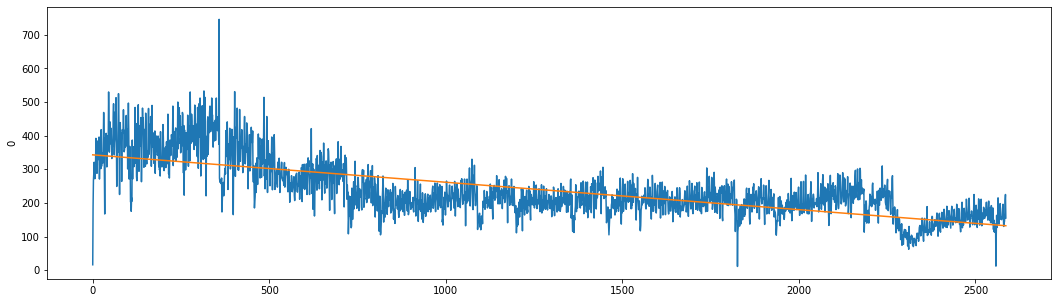

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(18, 5) ) 
sns.lineplot(dias,incidentes,ax=axes)
sns.lineplot(dias, y_predict);

In [ ]:
#Experimento 1

In [53]:
total = data_code_A['incidente_c4']=="accidente-choque con lesionados"
total

0         False
1          True
2         False
3          True
4          True
          ...  
614536    False
614537     True
614538    False
614539    False
614540    False
Name: incidente_c4, Length: 614541, dtype: bool

In [54]:
delegacion_accidente=pd.crosstab(data_code_A['delegacion_inicio'], data_code_A['incidente_c4']=="accidente-choque con lesionados")
delegacion_accidente

incidente_c4,False,True
delegacion_inicio,,
ALVARO OBREGON,34175,8064
AZCAPOTZALCO,22088,6546
BENITO JUAREZ,39729,11208
COYOACAN,37684,10107
CUAJIMALPA,7672,2039
CUAUHTEMOC,57084,16522
GUSTAVO A. MADERO,52304,14328
IZTACALCO,20561,6127
IZTAPALAPA,71339,17036


In [55]:
delegacion_accidente = delegacion_accidente.reset_index()
delegacion_accidente

incidente_c4,delegacion_inicio,False,True
0,ALVARO OBREGON,34175,8064
1,AZCAPOTZALCO,22088,6546
2,BENITO JUAREZ,39729,11208
3,COYOACAN,37684,10107
4,CUAJIMALPA,7672,2039
5,CUAUHTEMOC,57084,16522
6,GUSTAVO A. MADERO,52304,14328
7,IZTACALCO,20561,6127
8,IZTAPALAPA,71339,17036
9,MAGDALENA CONTRERAS,6359,1630


In [56]:
print(delegacion_accidente.columns)

Index(['delegacion_inicio', False, True], dtype='object', name='incidente_c4')


In [57]:
total_incidentes = delegacion_accidente.iloc[:,[2]].values.sum()
total_incidentes

131631

In [58]:
delegacion_accidente["días"]=2587
delegacion_accidente

incidente_c4,delegacion_inicio,False,True,días
0,ALVARO OBREGON,34175,8064,2587
1,AZCAPOTZALCO,22088,6546,2587
2,BENITO JUAREZ,39729,11208,2587
3,COYOACAN,37684,10107,2587
4,CUAJIMALPA,7672,2039,2587
5,CUAUHTEMOC,57084,16522,2587
6,GUSTAVO A. MADERO,52304,14328,2587
7,IZTACALCO,20561,6127,2587
8,IZTAPALAPA,71339,17036,2587
9,MAGDALENA CONTRERAS,6359,1630,2587


In [59]:
delegacion_accidente.describe()

incidente_c4,False,True,días
count,16.000000,16.000000,16.0
mean,30181.875000,8226.937500,2587.0
std,19674.976791,5101.804706,0.0
min,2733.000000,839.000000,2587.0
25%,15056.000000,3865.750000,2587.0
50%,30558.500000,8121.500000,2587.0
75%,40529.000000,10965.000000,2587.0
max,71339.000000,17036.000000,2587.0


In [60]:
#Si quisiéramos aplicar la misma probabilidad a cada evento, pero esto es un presupuesto un tanto irreal, fundado en la idea de que todos
#los incidentes viales del tipo "choque con lesionados", tendrían la misma probabilidad de ocurrir en cada una de las 16 delegaciones.
delegacion_accidente["prob"]= delegacion_accidente.iloc[:,[2]].values.mean() / total_incidentes
delegacion_accidente

incidente_c4,delegacion_inicio,False,True,días,prob
0,ALVARO OBREGON,34175,8064,2587,0.0625
1,AZCAPOTZALCO,22088,6546,2587,0.0625
2,BENITO JUAREZ,39729,11208,2587,0.0625
3,COYOACAN,37684,10107,2587,0.0625
4,CUAJIMALPA,7672,2039,2587,0.0625
5,CUAUHTEMOC,57084,16522,2587,0.0625
6,GUSTAVO A. MADERO,52304,14328,2587,0.0625
7,IZTACALCO,20561,6127,2587,0.0625
8,IZTAPALAPA,71339,17036,2587,0.0625
9,MAGDALENA CONTRERAS,6359,1630,2587,0.0625


In [61]:
# Con base a los datos recabados a lo largo del tiempo, podemos asignar probalidades particulares para cada una de las alcaldías
# con base a los datos registrados del 2014 a principios del 2021
delegacion_accidente["prob"]= delegacion_accidente.iloc[:,[2]].values / total_incidentes
delegacion_accidente

incidente_c4,delegacion_inicio,False,True,días,prob
0,ALVARO OBREGON,34175,8064,2587,0.061262
1,AZCAPOTZALCO,22088,6546,2587,0.049730
2,BENITO JUAREZ,39729,11208,2587,0.085147
3,COYOACAN,37684,10107,2587,0.076783
4,CUAJIMALPA,7672,2039,2587,0.015490
5,CUAUHTEMOC,57084,16522,2587,0.125518
6,GUSTAVO A. MADERO,52304,14328,2587,0.108850
7,IZTACALCO,20561,6127,2587,0.046547
8,IZTAPALAPA,71339,17036,2587,0.129422
9,MAGDALENA CONTRERAS,6359,1630,2587,0.012383


In [62]:
#Con base a los datos regitrados durante el periodo de tiempo, ¿Qué cantidad de accidentes del tipo "accidente-choque con lesionados"
#Para la alcaldía que más incidentes de este tipo ha tenido, para el final del año 2021 y para el final del año 2022?

In [63]:
print(delegacion_accidente.columns)

Index(['delegacion_inicio', False, True, 'días', 'prob'], dtype='object', name='incidente_c4')


In [64]:
x = delegacion_accidente.iloc[:,[3,4]].values
y = delegacion_accidente.iloc[:,[2]].values

In [65]:
from sklearn.model_selection import train_test_split

In [70]:
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size = 0.1, random_state=2)

In [67]:
regressor = LinearRegression()
prediccion = regressor.fit(x_train, y_train)

In [68]:
# Genere una predicción del número de accidentes del tipo "accidente-choque con lesionados para el final del año 2021 (días = 2915), si la probalidad de incidencia
# aumentara un 10% para el final de ese, y qué cantidad de accidentes de choque con lesionados podría predecire al final del año 2022 
#(días = 3279) si disminuyera un 7% la probabilidad de incidencia con respecto al final del 2021. 
# para la alcaldía IZTAPALA que ha registrado un total de 17036 con una probabilidad de 0.129422
pred_incidente_c4 = np.array([[2915,0.229422],[3279,0.179422]])
#linear_regression.predict(var1)
prediccion.predict(pred_incidente_c4)

array([[30199.047282],
       [23617.497282]])

In [69]:
#Calcule la R2 cuadrada para el modelo de regresión múltiple
regressor.score(x_test,y_test)

1.0

## 7. Cluster

In [71]:
H,xc,yc = mayor_densidad(data=data_code_A,x='longitud',y='latitud',umbral=500,escala=0.3/111.1)

In [72]:
mayor_incidentes = pd.DataFrame({'longitud':xc,'latitud':yc})
mayor_incidentes = transform_data(mayor_incidentes)

[(19.09402002, 19.579320000000006), (-99.35449897, -98.94537)]

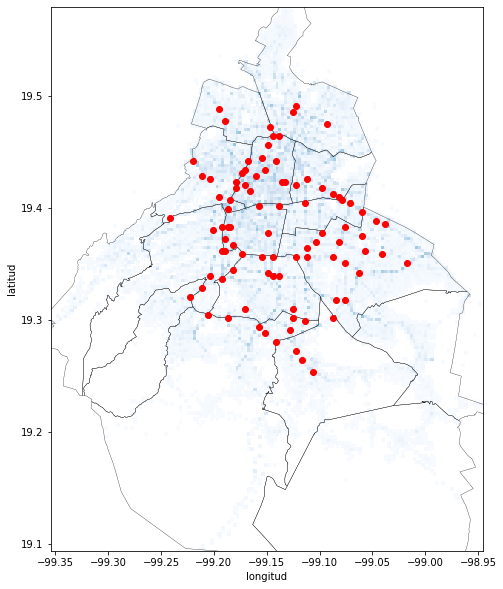

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10) ) 

sns.histplot(data=data_code_A,x='longitud',y ='latitud',
             cmap='Blues',ax=axes,binwidth=0.3/111.1,kde=True)
alcaldias.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.3 )

#viasprincipales.plot(ax=axes, edgecolor='red', lw=0.5,alpha=0.5 )

axes.scatter(xc,yc,color='red')

axes.set(xlim =(data_code_A['longitud'].min(),data_code_A['longitud'].max()),
         ylim =(data_code_A['latitud'].min(),data_code_A['latitud'].max()))

In [74]:
k_means = KMeans(n_clusters=5, max_iter=10000)
clasificacion = k_means.fit(mayor_incidentes[['longitud','latitud']])
centers = k_means.cluster_centers_
pred = k_means.predict(mayor_incidentes[['longitud','latitud' ]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(19.09402002, 19.579320000000006), (-99.35449897, -98.94537)]

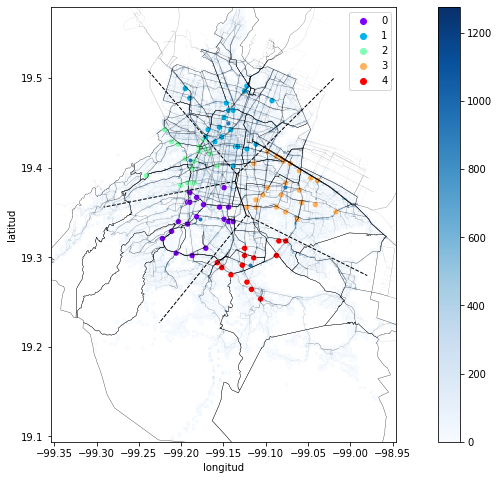

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(15, 8) ) 


sns.histplot(data_code_A,x='longitud',y ='latitud',cmap='Blues',
             ax=axes,binwidth=0.3/111.1,kde=True, cbar=True)
alcaldias.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.3 )

rutas.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.1,alpha=0.1 )

v = Voronoi(centers)
voronoi_plot_2d(v,ax=axes,show_vertices=False)
viasprincipales.plot(ax=axes,markersize=0.5,facecolor="none", edgecolor='black', lw=0.5,alpha=0.3 )

sns.scatterplot(mayor_incidentes['longitud'], mayor_incidentes['latitud'], ax=axes, hue=pred , palette='rainbow');

axes.set(xlim =(data_code_A['longitud'].min(),data_code_A['longitud'].max()),
         ylim =(data_code_A['latitud'].min(),data_code_A['latitud'].max()))



Se realizó una clasificación a los datos de alta densidad de incidentes. Se considero una clasficiación en 6 regiones las cuales serviran para estudiar a futuro la relación de las vías principales dentro de cada una de ellas. El resultado de la clasficación son poligonos 5 poligonos que se distribuyes al rededor de otro. 